# Sentiment Analysis
### Usman Bala Usman (contact.usmanusman@gmail.com)

### Project Description:
In this project, we train a logistic regression model for sentiment analysis using the Twitter Sentiment140 dataset to correctly classify tweets as either positive or negative.

The project is separated into three steps:

*   Data Processing and EDA
*   Feature Selection and Engineering
*   Model Training and Evaluation

## Imports

We load all the relevant data science and machine learning libraries required for the execution of the project.

Also, we import utility libraries to aid in our data fetching.

Data is loaded from a remote location if not present in the current runtime.

In [59]:
%pip install -q beautifulsoup4 seaborn matplotlib wordcloud scikit-learn keras nltk tensorflow joblib


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [60]:
import random
import re
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_curve, auc, mean_squared_error, mean_squared_error, accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import joblib

import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to /home/codegeek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/codegeek/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [61]:
filename = 'MP2_Sentiment140.tsv'

In [62]:
data = pd.read_csv(filename, sep='\t', header=0)

In [63]:
data.head()

,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   sentiment_label  160000 non-null  int64 
 1   tweet_text       160000 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [65]:
data.sentiment_label.value_counts()

sentiment_label
4    80000
0    80000
Name: count, dtype: int64

In [66]:
label_to_sentiment = {0:"Negative", 4:"Positive"}

def label_decoder(label):
  return label_to_sentiment[label]
data.sentiment_label = data.sentiment_label.apply(lambda x: label_decoder(x))

In [67]:
data.head()

,sentiment_label,tweet_text
0,Positive,"@elephantbird Hey dear, Happy Friday to You A..."
1,Positive,Ughhh layin downnnn Waiting for zeina to co...
2,Negative,"@greeniebach I reckon he'll play, even if he's..."
3,Negative,@vaLewee I know! Saw it on the news!
4,Negative,very sad that http://www.fabchannel.com/ has c...


Text(0.5, 1.0, 'Sentiment Data Distribution')

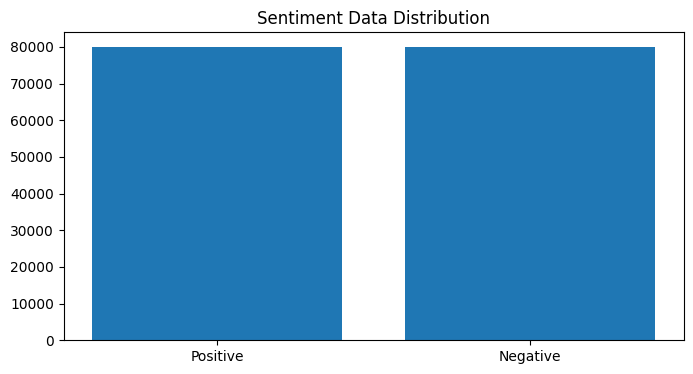

In [68]:
val_count = data.sentiment_label.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

We can see that the dataset contains a balanced distribution of **Positive** and **Negative** sentiments. This is vital in training machine learning models as unbalanced datasets can introduce bias in the model and cause a weaker performance in one of the classes

In [69]:
random_idx_list = [random.randint(1,len(data.tweet_text)) for i in range(10)]
data.loc[random_idx_list,:].head(10)

,sentiment_label,tweet_text
39294,Negative,@KatrinaBTW that would make me so paranoid. I ...
23575,Negative,Im so over working But there is really good a...
82096,Negative,The world is against me today. Even my hair do...
102326,Positive,@gfalcone601 =D yayyy. thankyou for reply...it...
107130,Positive,@moijojojo you on G Moiz? ? Send me an invite ...
6705,Negative,"@Freesia13 Toast IS tempting, but trying to re..."
22205,Negative,is sad i have to miss the @rascalflatts Bristo...
19643,Positive,@glennisglitters glad you got home safely!! se...
137551,Negative,@woosang hehe thanks but i should have lost th...
63971,Positive,@Rach33 it just is


We display a list of some random tweets to have a look at the content and get to understand the text better before progressing to the preprocessing stage.

Below, we display a WordCloud highlighting the words most common in texts labeled with **Positive** sentiment.

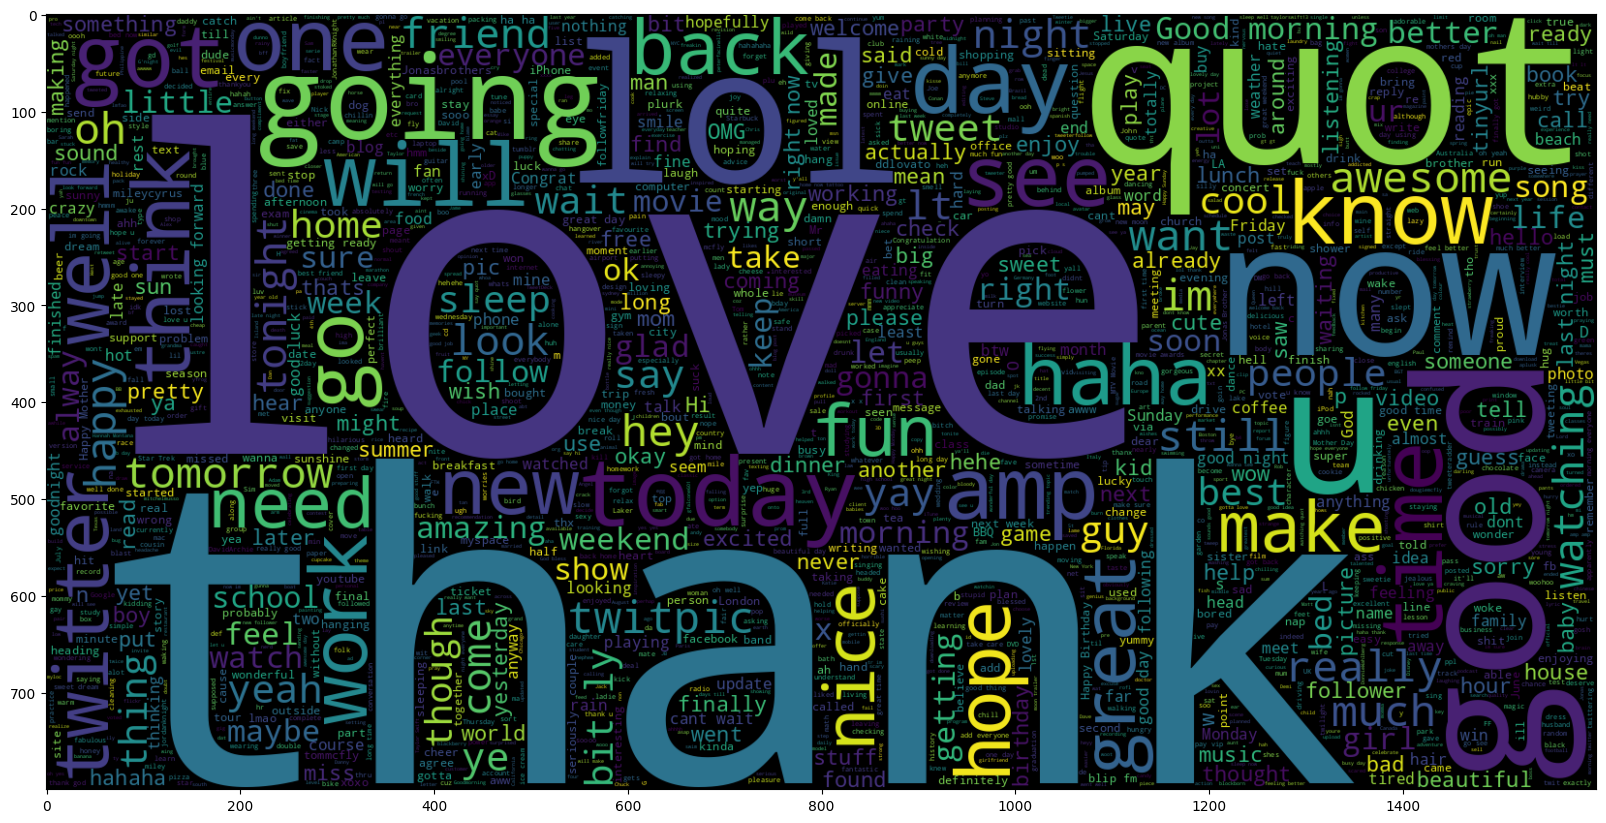

In [70]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.sentiment_label == 'Positive'].tweet_text))
plt.imshow(wc , interpolation = 'bilinear')

We also display the corresponding WordCloud for the most common words with **Negative** sentiment as well.

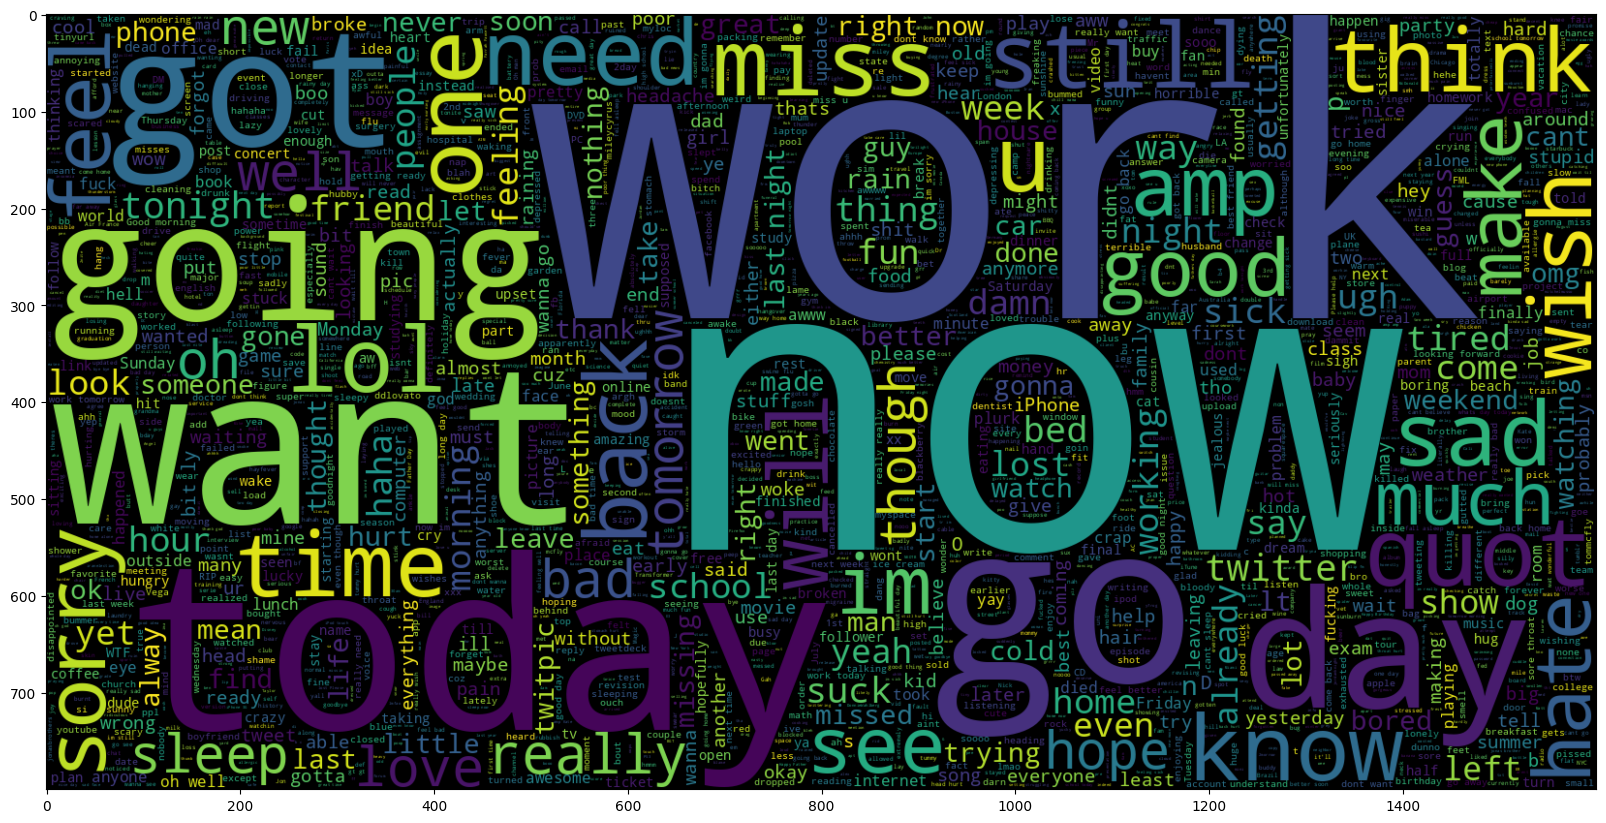

In [71]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.sentiment_label == 'Negative'].tweet_text))
plt.imshow(wc , interpolation = 'bilinear')

## Data Processing

In this stage, which can be argued as the most important step in any Natural Language Processing (NLP) project, we perform text processing to clean our text and use standard NLP techniques to prepare the text for further vectored processing to train our machine learning models. The steps performed in this stage are as follows:



1.   **Removal of unwanted characters**: Since the source of the text is Tweets, one of the most common character occurances is then the **@** sign which signifies usernames. We remove the tag and subsequently remove unwanted spaces and single character words. This is because a single character words would contain no context and therefore not be useful for a machine learning model.
2.   **Tokenization**: This refers to the process of breaking down a text or a sequence of characters into smaller units called tokens. These tokens can be words, phrases, symbols, or other meaningful elements, depending on the context and the specific task at hand. Tokenization is a fundamental step in NLP preprocessing because it enables computers to understand and process human language by treating each token as a discrete unit.
3.  **Text Normalization**: The most common text normalization techniques are stemming and lemmatization. **Stemming** refers to the process of reducing words to their root or base form, known as the stem while **Lemmatization** which the process of reducing words to their base or dictionary form, known as the lemma. Unlike stemming, which simply chops off affixes from words, lemmatization takes into account the morphological analysis of words and aims to transform them into their canonical or dictionary form. We proceed with Lemmatization.

We then store the clean tweets in a separate column for further processing.


In [72]:
def clean_tweet(tweet):

    tweet = BeautifulSoup(tweet, 'html.parser').get_text()

    tweet = re.sub(r'@[^\s]+', '', tweet)

    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)
    tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', tweet)
    tweet = re.sub(r'\s+', ' ', tweet)

    return tweet.strip()

In [73]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()

    words = word_tokenize(text)

    words = [lemmatizer.lemmatize(word) for word in words]

    processed_text = ' '.join(words)

    return processed_text

In [49]:
data['cleaned_text'] = data['tweet_text'].apply(clean_tweet)

In [50]:
data['cleaned_text'] = data['cleaned_text'].apply(preprocess_text)

In [51]:
data['cleaned_text'].head(20)

0     hey dear happy friday to you already had your ...
1     ughhh layin downnnn waiting for zeina to cook ...
2     reckon hell play even if he not but know nothi...
3                               know saw it on the news
4     very sad that httpwwwfabchannelcom ha closed d...
5     who sings remember alwaysss hear it on radio b...
6              with god on ur side anything is possible
7                                      why being stupid
8     having delved back into the gut of expression ...
9                                awww take him with you
10     the video on vh is much better than the tube one
11    i ran out of champagne wonder if call my broth...
12                    wish wa going to the show tonight
13    doing homeworkthen bedwaking up at is gon na b...
14    ashleyltmsyf hey ashley when will the hush hus...
15    scratch that enjoy seein people that left for ...
16    hey im good sorry took so long reply and im ju...
17    good morning youre up early chilling and c

The sample above shows the text after it was processed

In [52]:
label_encoder = LabelEncoder()
data['sentiment_label'] = label_encoder.fit_transform(data['sentiment_label'])

# Modelling

In this section, we perform further feature engineering with Term Frequency Vectorization and then proceed to train the model using Logistic Regression.

## Term Frequency Vectorization

The TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer is a powerful tool in natural language processing (NLP) used for extracting features from text data. It operates by transforming a collection of raw text documents into a matrix of TF-IDF features. TF-IDF consists of two main components: Term Frequency (TF) and Inverse Document Frequency (IDF). TF measures how often a term appears in a document relative to the total number of terms in that document, while IDF measures the importance of a term across the entire corpus, assigning higher weights to terms that are rare across documents but common within a specific document. The TF-IDF score of a term in a document is the product of its TF and IDF scores, indicating the term's importance in the context of the entire corpus.

In [53]:
tfidf_vectorizer = TfidfVectorizer()
X_vect = tfidf_vectorizer.fit_transform(data['cleaned_text'])

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_vect, data['sentiment_label'], test_size=0.2, random_state=42)


### Logistic Regression

In [55]:
lg_model = LogisticRegression(max_iter=1000)
lg_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

### Save model and vectorizer

In [56]:
joblib.dump(lg_model, './model/sentiment_model.joblib')
joblib.dump(tfidf_vectorizer, './model/tfidf_vectorizer.joblib')

['./model/tfidf_vectorizer.joblib']

### Measure accuracy

In [57]:
lg_pred = lg_model.predict(X_test)

lg_vec_accuracy = accuracy_score(y_test, lg_pred)

print("Logistic Regression Accuracy:", lg_vec_accuracy)
print("Logistic Regression Mean Squared Error (MSE):", mean_squared_error(y_test, lg_pred))
print("Logistic Regression Classification Report:\n", classification_report(y_test, lg_pred))


Logistic Regression Accuracy: 0.78428125
Logistic Regression Mean Squared Error (MSE): 0.21571875
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.77      0.78     16002
           1       0.77      0.80      0.79     15998

    accuracy                           0.78     32000
   macro avg       0.78      0.78      0.78     32000
weighted avg       0.78      0.78      0.78     32000



### Model Performance

/tmp/ipykernel_52710/4033499344.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


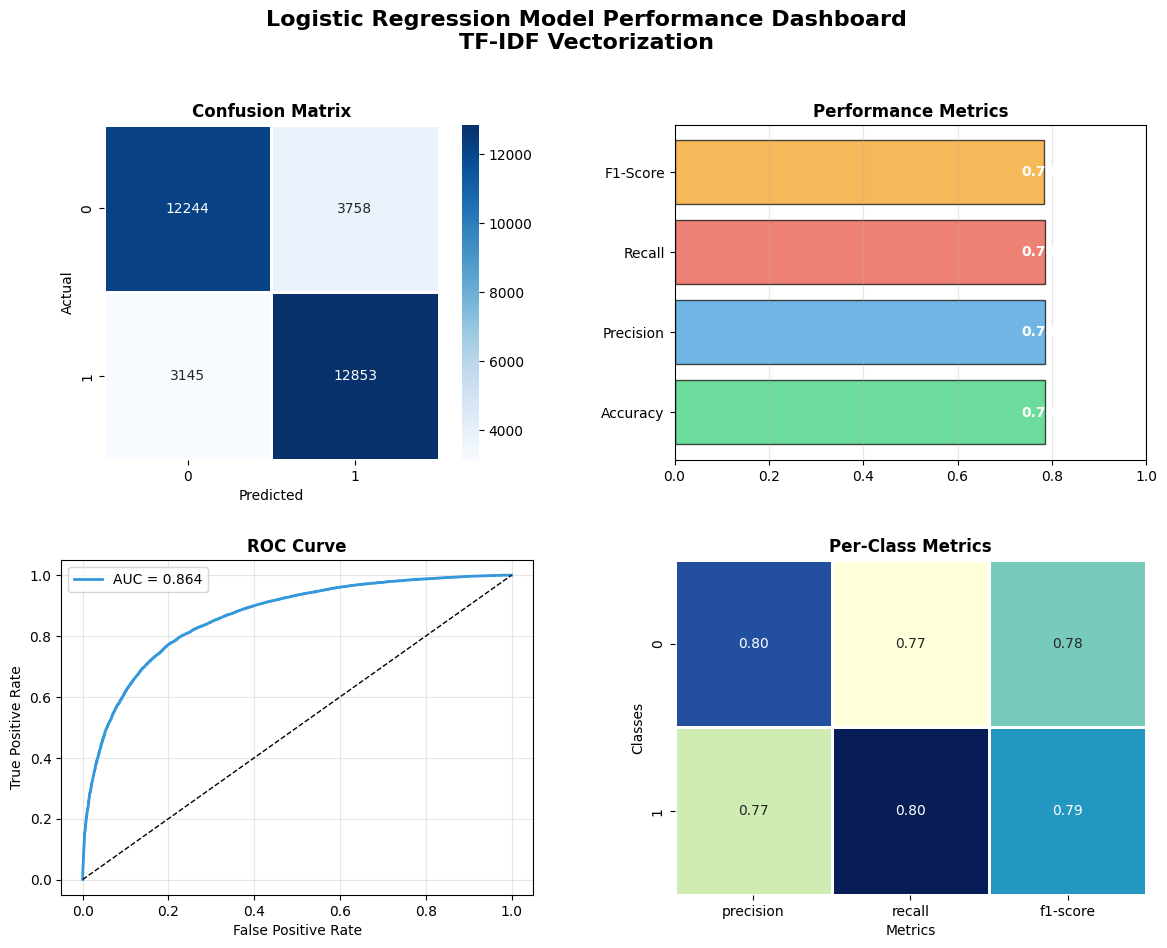

In [58]:
# Calculate all metrics
metrics = {
    'Accuracy': accuracy_score(y_test, lg_pred),
    'Precision': precision_score(y_test, lg_pred, average='weighted'),
    'Recall': recall_score(y_test, lg_pred, average='weighted'),
    'F1-Score': f1_score(y_test, lg_pred, average='weighted')
}

colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']


fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Confusion Matrix
ax1 = fig.add_subplot(gs[0, 0])
cm = confusion_matrix(y_test, lg_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            square=True, ax=ax1, linewidths=1)
ax1.set_title('Confusion Matrix', fontweight='bold')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Metrics Bar Chart
ax2 = fig.add_subplot(gs[0, 1])
bars = ax2.barh(list(metrics.keys()), list(metrics.values()), 
                color=colors, alpha=0.7, edgecolor='black')
ax2.set_xlim([0, 1])
ax2.set_title('Performance Metrics', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
for i, (metric, value) in enumerate(metrics.items()):
    ax2.text(value - 0.05, i, f'{value:.3f}', 
            va='center', fontsize=10, fontweight='bold', color='white')

# ROC Curve
if len(np.unique(y_test)) == 2:
    ax3 = fig.add_subplot(gs[1, 0])
    y_pred_proba = lg_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    ax3.plot(fpr, tpr, color='#3498db', linewidth=2, label=f'AUC = {roc_auc:.3f}')
    ax3.plot([0, 1], [0, 1], 'k--', linewidth=1)
    ax3.set_title('ROC Curve', fontweight='bold')
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.legend()
    ax3.grid(alpha=0.3)

# Per-Class Metrics
ax4 = fig.add_subplot(gs[1, 1])
report_df = pd.DataFrame(classification_report(y_test, lg_pred, output_dict=True)).transpose()
report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')
sns.heatmap(report_df.iloc[:, :-1], annot=True, fmt='.2f', 
            cmap='YlGnBu', cbar=False, ax=ax4, linewidths=1)
ax4.set_title('Per-Class Metrics', fontweight='bold')
ax4.set_xlabel('Metrics')
ax4.set_ylabel('Classes')

fig.suptitle('Logistic Regression Model Performance Dashboard\nTF-IDF Vectorization', 
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

# Conclusion

## Summary of Findings
In this project, we performed sentiment analysis on a truncated version of the Twitter Sentiment140 dataset, which contains 160,000 tweets. The workflow involved:
1. **Data Processing & EDA**: Cleaning the text data and visualizing the sentiment distribution (which was balanced between positive and negative (80,000 each)).
2. **Feature Selection & Engineering**: We utilized **TF-IDF (Term Frequency-Inverse Document Frequency)** vectorization to convert text into numerical features, which effectively captured the importance of words in the corpus.
3. **Model Training & Evaluation**: Several models were considered, with **Logistic Regression** serving as a strong baseline.

## Model Performance
The Logistic Regression model achieved an accuracy of approximately **78.4%** on the test set.
- **Accuracy**: 0.784
- **Precision/Recall/F1-Score**: ~0.78 for both classes, indicating a well-balanced model that doesn't significantly favor one sentiment over the other.

## Key Insights
- Preprocessing steps like removing stop words and handling special characters are crucial for reducing noise in social media data.
- TF-IDF with Logistic Regression provides a computationally efficient and high-performing solution for large-scale tweet classification.

## Future Work
- **Sentiment Refinement**: Inclusion of an 'Intermediate' or 'Neutral' class if data becomes available.
- **Real-time Analysis**: Implementing a streaming pipeline to analyze live tweets using the trained model.